In [1]:
import numpy as np
import nibabel as nib
from scipy.signal import butter, filtfilt, hilbert
import matplotlib.pyplot as plt
import h5py
%matplotlib inline
subjects = np.loadtxt('../100unrelatedsubjectsIDs.txt', dtype='str')
p = 116
K = 5
T = 1200
num_subs = 10

In [2]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="bandpass")
    return b, a

# Apply Filter
# Changed by Anders to be correct range (from 0.01-0.1 to 0.009-0.08)
def butter_bandpass_filter(data, lowcut=0.009, highcut=0.08, fs=1 / 0.720, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [3]:
atlas = nib.load('../data/external/Schaefer2018_100Parcels_7Networks_order_Tian_Subcortex_S1.dlabel.nii')
atlas_data = atlas.get_fdata()
atlas_data = np.round(atlas_data)
atlas_data = atlas_data.astype(int)[0]
filtered_data_all = []

for sub in subjects[:10]:
    img = nib.load('../data/raw/'+sub+'/fMRI/rfMRI_REST1_RL_Atlas_MSMAll_hp2000_clean.dtseries.nii')
    data = img.get_fdata()
    data = data - np.mean(data, axis=0)

    GS = np.mean(data[:,:59412], axis=1)
    data = data - GS[:,None]*(data.T@GS).T/(GS.T@GS)
    
            # GS = mean(data(:,1:59412),2);
            # data = data-GS.*(data'*GS)'/(GS'*GS);
    # parcellate data in atlas
    parcellated_data = np.zeros((data.shape[0], atlas_data.max()))
    for i in range(1, atlas_data.max()+1):
        parcellated_data[:,i-1] = np.mean(data[:,atlas_data == i], axis=1)
    # filter data
    filtered_data = np.zeros(parcellated_data.shape)
    for i in range(p):
        filtered_data[:,i] = butter_bandpass_filter(parcellated_data[:,i])
    filtered_data_all.append(filtered_data)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Text(0, 0.5, 'ROI')

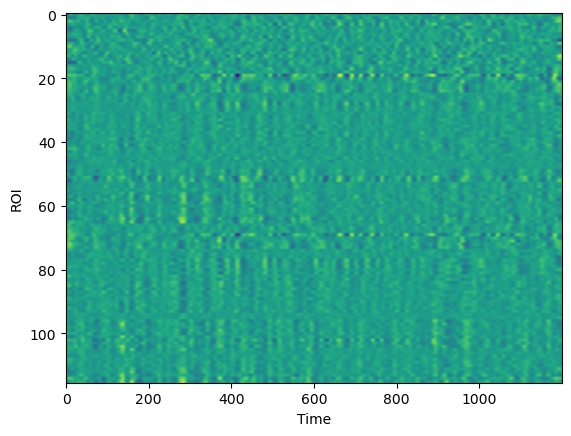

In [4]:
plt.figure()
plt.imshow(filtered_data_all[1].T, aspect='auto');
plt.xlabel('Time')
plt.ylabel('ROI')

Set phase information equal to template phases, maintain existing amplitude information

In [21]:
num_repeats = 1 #repeats of clustering pattern state1..state2.. etc

times = np.linspace(0, 1200, K*num_repeats+1, dtype=int)
num_samples = times[1]-times[0]
num_add = num_samples//10
TR = 0.720
f = np.fft.fftfreq(num_samples+num_add*2, 1/TR)
# find indices of frequencies above or equal to 0.008Hz and below or equal to 0.09Hz
positive_frequency_content_indices = np.where((f>=0.009) & (f<=0.08))[0]
negative_frequency_content_indices = np.where((f<=-0.009) & (f>=-0.08))[0]
num_phases = len(positive_frequency_content_indices)

nodes = [0, 23, 46, 69, 92]
nodes = np.tile(nodes, num_repeats)
specs = []
for window in range(K*num_repeats):
    ref = filtered_data_all[0][times[window]:times[window+1],nodes[window]]
    specs.append(np.fft.fft(ref))

phase_reset_data_all = []
phase_shifts = np.random.rand(p)*2*np.pi-np.pi #within-cluster phase shifts equal across subjects
for sub in range(num_subs):
    newdata = np.zeros((T,p))
    for window in range(K*num_repeats):
        for i in range(p):
            signal = filtered_data_all[sub][times[window]:times[window+1],i]
            if num_add>0:
                signal = np.concatenate((2*signal[0]-np.flip(signal[1:num_add+1]),signal,2*signal[-1]-np.flip(signal[-num_add-1:-1])))
            signal_spec = np.fft.fft(signal)
            # signal_spec = signal_spec[]
            if nodes[window]==nodes[-1]:
                if i>=nodes[window]:
                    phases = np.full(num_phases,phase_shifts[i])
                    new_phases = np.angle(signal_spec)
                    new_phases[positive_frequency_content_indices] = phases
                    new_phases[negative_frequency_content_indices] = -phases[::-1]
                    tmp = np.abs(signal_spec) * np.exp(1j*new_phases)
                else:
                    phases = np.random.rand(num_phases)*2*np.pi-np.pi
                    new_phases = np.angle(signal_spec)
                    new_phases[positive_frequency_content_indices] = phases
                    new_phases[negative_frequency_content_indices] = -phases[::-1]
                    tmp = np.abs(signal_spec) * np.exp(1j*new_phases)
            else:
                if i<nodes[window+1] and i>=nodes[window]:
                    phases = np.full(num_phases,phase_shifts[i])
                    new_phases = np.angle(signal_spec)
                    new_phases[positive_frequency_content_indices] = phases
                    new_phases[negative_frequency_content_indices] = -phases[::-1]
                    tmp = np.abs(signal_spec) * np.exp(1j*new_phases)
                else:
                    phases = np.random.rand(num_phases)*2*np.pi-np.pi
                    new_phases = np.angle(signal_spec)
                    new_phases[positive_frequency_content_indices] = phases
                    new_phases[negative_frequency_content_indices] = -phases[::-1]
                    tmp = np.abs(signal_spec) * np.exp(1j*new_phases)
            
            # imaginary part is negligible
            new_signal = np.fft.ifft(tmp).real
            if num_add>0:
                new_signal = new_signal[num_add:-num_add]
            newdata[times[window]:times[window+1],i] = new_signal

    phase_reset_data_all.append(newdata)

In [20]:
num_samples+num_add

264

In [41]:
phase_reset_data = np.concatenate(phase_reset_data_all, axis=0)
with h5py.File('../data/synthetic/phase_controlled_116data.h5', 'w') as f:
    f.create_dataset("X", data=phase_reset_data)

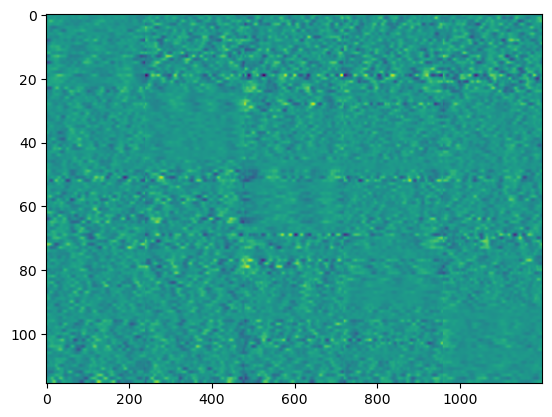

In [22]:
plt.figure()
plt.imshow(phase_reset_data_all[1].T, aspect='auto');

Calculate LEiDA

In [23]:
U_all = []
S_all = []
for sub in range(10):
    phases = np.zeros((phase_reset_data_all[sub].shape[0], p))
    for i in range(p):
        phases[:,i] = np.angle(hilbert(phase_reset_data_all[sub][:,i]))
    U_all_sub = np.zeros((T,p,2))
    S_all_sub = np.zeros((T,2))
    for t in range(T):
        c = np.cos(phases[t])
        s = np.sin(phases[t])
        U,S,_ = np.linalg.svd(np.c_[c,s], full_matrices=False)
        U_all_sub[t] = U
        S_all_sub[t] = S
    U_all.append(U_all_sub)
    S_all.append(S_all_sub)
U_tmp = np.concatenate(U_all, axis=0)

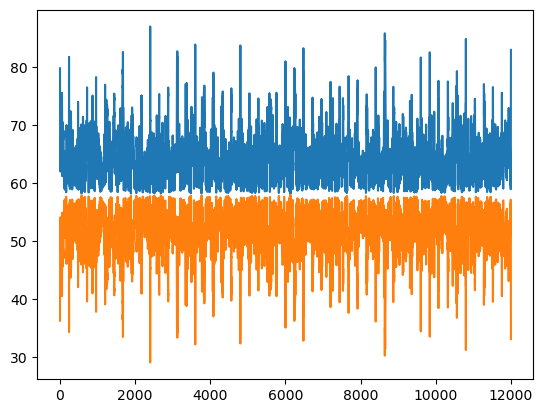

In [24]:
S_tmp = np.concatenate(S_all, axis=0)
plt.plot(S_tmp[0:]**2)
# plt.xlim([0,242])

In [27]:
from src.DMM_EM.riemannian_clustering import diametrical_clustering, grassmannian_clustering_gruber2006
C_DC,_,_ = diametrical_clustering(U_tmp[:,:,0],K=K)
# C_GC = grassmannian_clustering_gruber2006(U_tmp,K=K)

In [28]:
sim_DC = np.zeros((U_tmp.shape[0],K))
sim_GC = np.zeros((U_tmp.shape[0],K))
seq = np.zeros(U_tmp.shape[0])
for t in range(U_tmp.shape[0]):
    for c in range(K):
        # sim_GC[t,c] = 1-np.linalg.norm(U_tmp[t]@U_tmp[t].T - C_GC[c]@C_GC[c].T)
        sim_DC[t,c] = (U_tmp[t,:,0] @ C_DC[:,c])**2
    seq[t] = np.argmax(sim_DC[t])

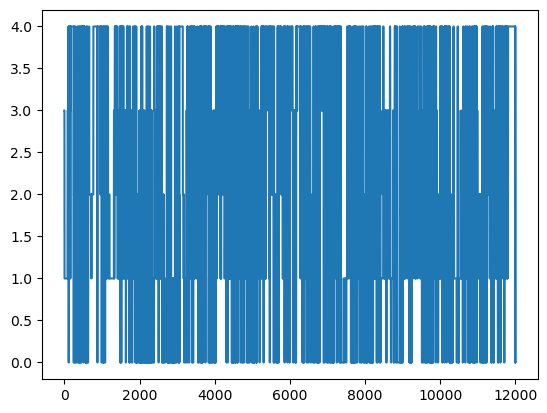

In [29]:
plt.plot(seq)

<BarContainer object of 116 artists>

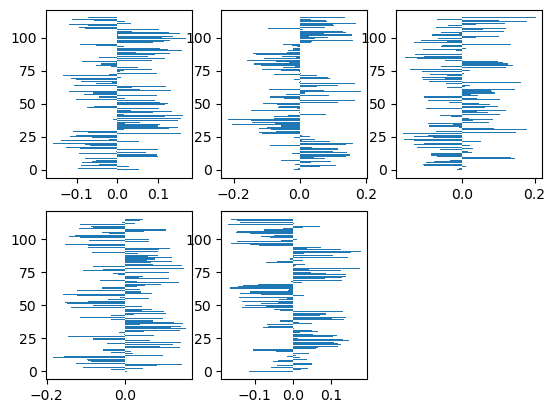

In [30]:
plt.subplot(2,3,1)
plt.barh(range(p),C_DC[:,0])
plt.subplot(2,3,2)
plt.barh(range(p),C_DC[:,1])
plt.subplot(2,3,3)
plt.barh(range(p),C_DC[:,2])
plt.subplot(2,3,4)
plt.barh(range(p),C_DC[:,3])
plt.subplot(2,3,5)
plt.barh(range(p),C_DC[:,4])
# plt.subplot(2,3,6)
# plt.barh(range(p),C_DC[:,5])
# plt.barh(range(p),C_GC[0,:,0])
# plt.barh(range(p),C_GC[0,:,1])
# plt.subplot(2,3,5)
# plt.barh(range(p),C_GC[1,:,0])
# plt.barh(range(p),C_GC[1,:,1])
# plt.subplot(2,3,6)
# plt.barh(range(p),C_GC[2,:,0])
# plt.barh(range(p),C_GC[2,:,1])
# plt.show()

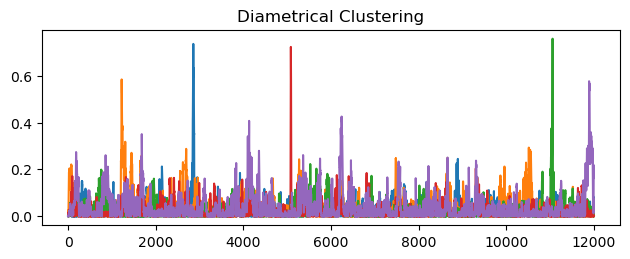

In [31]:
plt.subplot(2,1,1)
plt.plot(sim_DC)
plt.title('Diametrical Clustering')
# plt.subplot(2,1,2)
# plt.plot(sim_GC)
# plt.title('Grassmannian Clustering')
plt.tight_layout()

In [34]:
# use h5py to save this data (U_all)
with h5py.File('../data/synthetic/phase_controlled_116data_eida.h5', 'w') as f:
    f.create_dataset("U", data=U_tmp)